In [ ]:
import numpy as np
import pandas as pd
import os
import spacy
import en_core_web_sm
from spacy.lang.en import English
from spacy.lang.en.stop_words import STOP_WORDS
import string
from sklearn.model_selection import train_test_split
from sklearn.linear_model import LogisticRegression
from sklearn import metrics
from sklearn.feature_extraction import DictVectorizer
from sklearn.feature_extraction.text import CountVectorizer,TfidfVectorizer,HashingVectorizer
from sklearn.base import TransformerMixin
from sklearn.pipeline import Pipeline
!pip install vaderSentiment
import vaderSentiment
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/


In [ ]:
!pip install -U -q PyDrive
from pydrive.auth import GoogleAuth
from pydrive.drive import GoogleDrive
from google.colab import auth
from oauth2client.client import GoogleCredentials
auth.authenticate_user()
gauth = GoogleAuth()
gauth.credentials = GoogleCredentials.get_application_default()
drive = GoogleDrive(gauth)


from google.colab import drive
drive.mount('/content/gdrive')

Drive already mounted at /content/gdrive; to attempt to forcibly remount, call drive.mount("/content/gdrive", force_remount=True).


In [ ]:
# preprocessing the data file
#  read the data
df1 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/drugsComTrain_raw.csv")
df2 = pd.read_csv("/content/gdrive/MyDrive/Colab Notebooks/drugsComTest_raw.csv")
# combine two file
df = pd.concat([df1, df2])
df
# rename the cols
df.columns = ['ID','drug name','condition','review','rating','date','useful count']

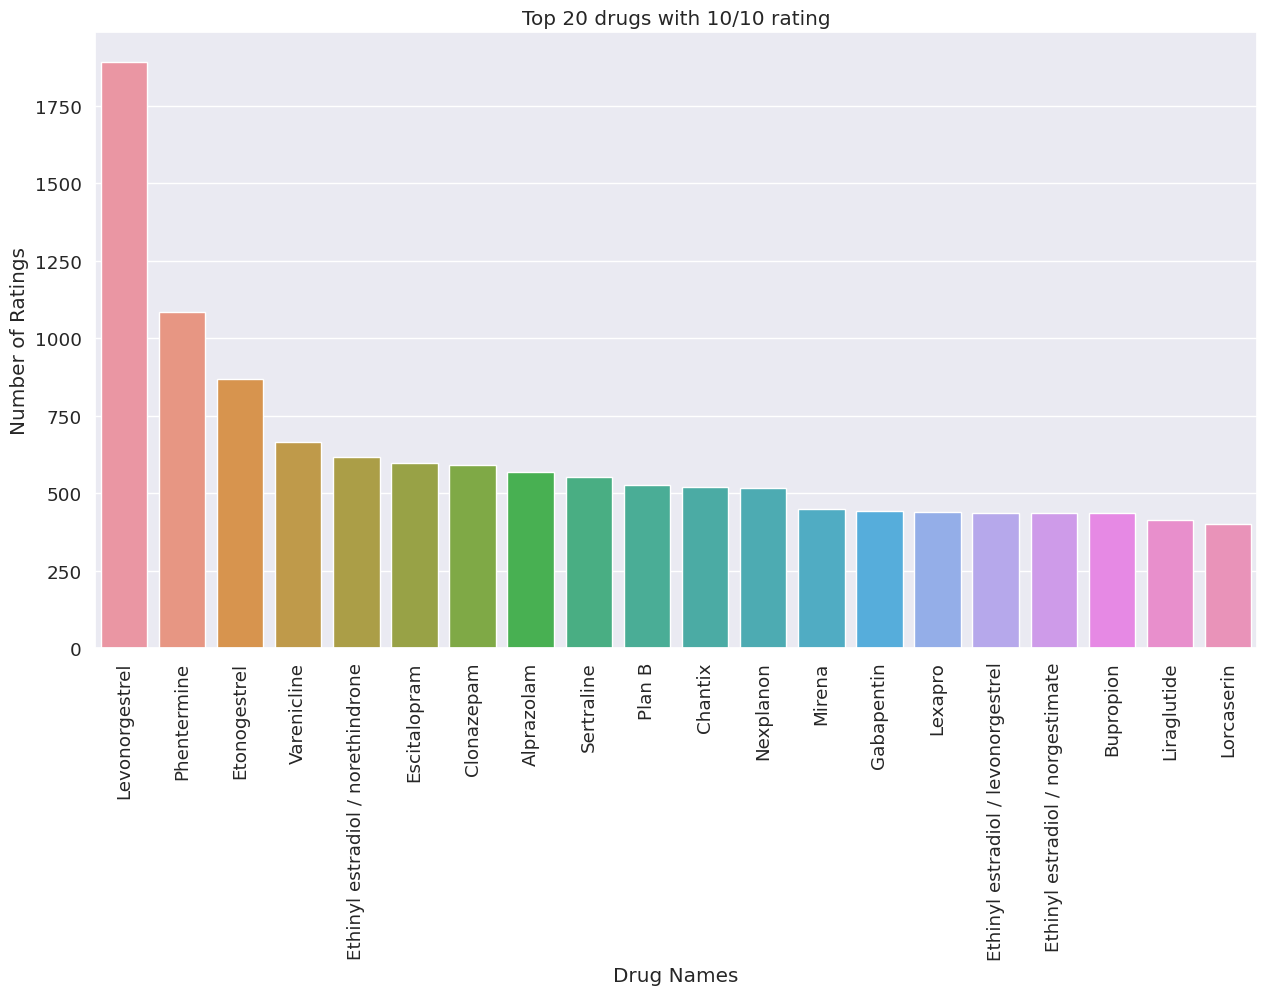

In [ ]:
import seaborn as sns
#!pip install matplotlib
import matplotlib.pyplot as plt

# Setting the Parameter
sns.set(font_scale = 1.2, style = 'darkgrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 10, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20])

sns_rating.set_title('Top 20 drugs with 10/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

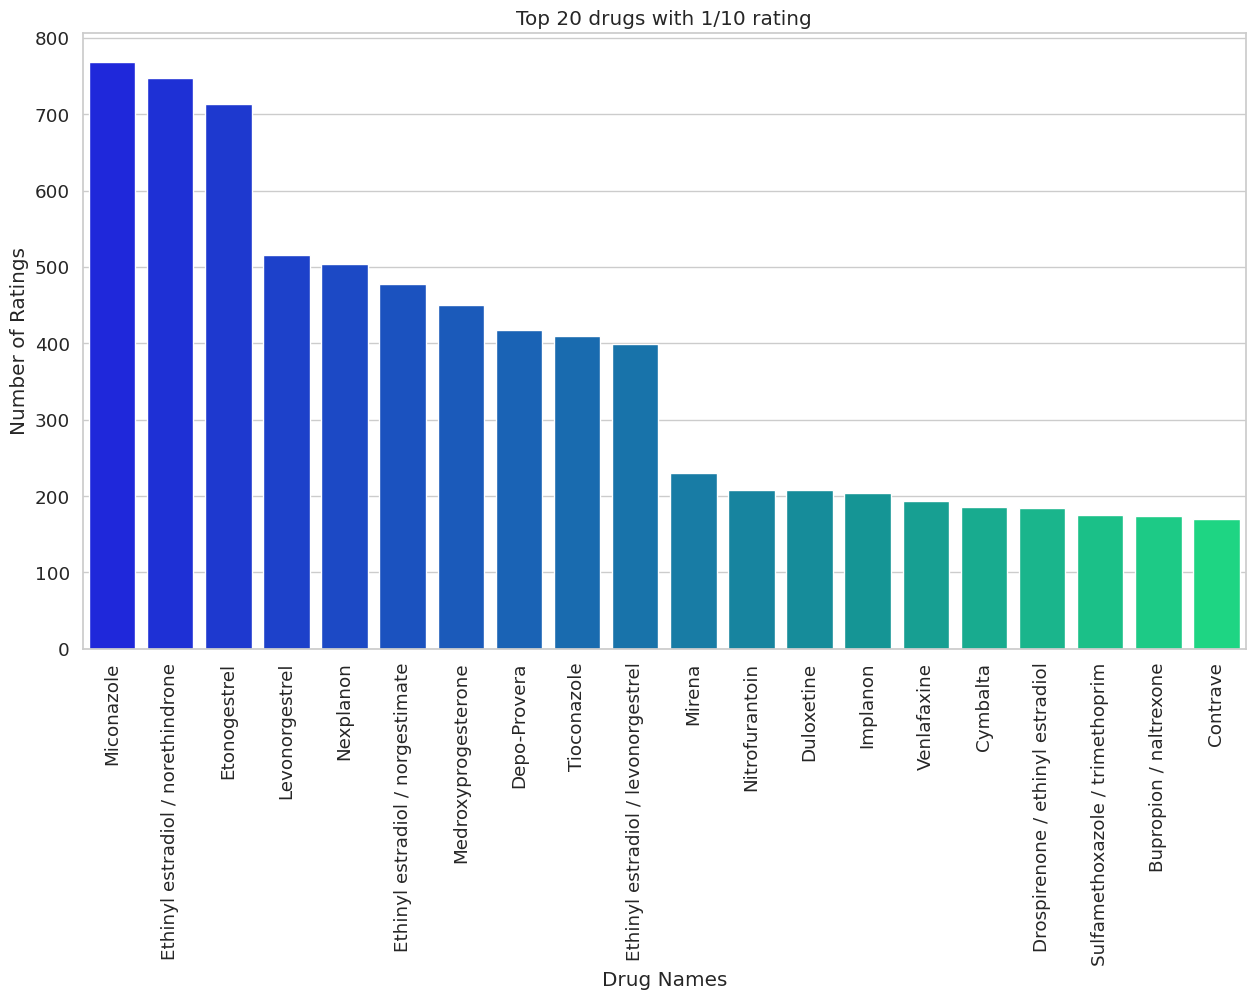

In [ ]:
# Setting the Parameter
sns.set(font_scale = 1.2, style = 'whitegrid')
plt.rcParams['figure.figsize'] = [15, 8]

rating = dict(df.loc[df.rating == 1, "drug name"].value_counts())
drugname = list(rating.keys())
drug_rating = list(rating.values())

sns_rating = sns.barplot(x = drugname[0:20], y = drug_rating[0:20], palette = 'winter')

sns_rating.set_title('Top 20 drugs with 1/10 rating')
sns_rating.set_ylabel("Number of Ratings")
sns_rating.set_xlabel("Drug Names")
plt.setp(sns_rating.get_xticklabels(), rotation=90);

In [ ]:
df.columns

Index(['ID', 'drug name', 'condition', 'review', 'rating', 'date',
       'useful count'],
      dtype='object')

<ipython-input-52-ca76ccecdffc>:6: UserWarning: 

`distplot` is a deprecated function and will be removed in seaborn v0.14.0.

Please adapt your code to use either `displot` (a figure-level function with
similar flexibility) or `histplot` (an axes-level function for histograms).

For a guide to updating your code to use the new functions, please see
https://gist.github.com/mwaskom/de44147ed2974457ad6372750bbe5751

  sns_2 = sns.distplot(df['rating'], ax = ax[1])


Text(0.5, 0, 'Rating')

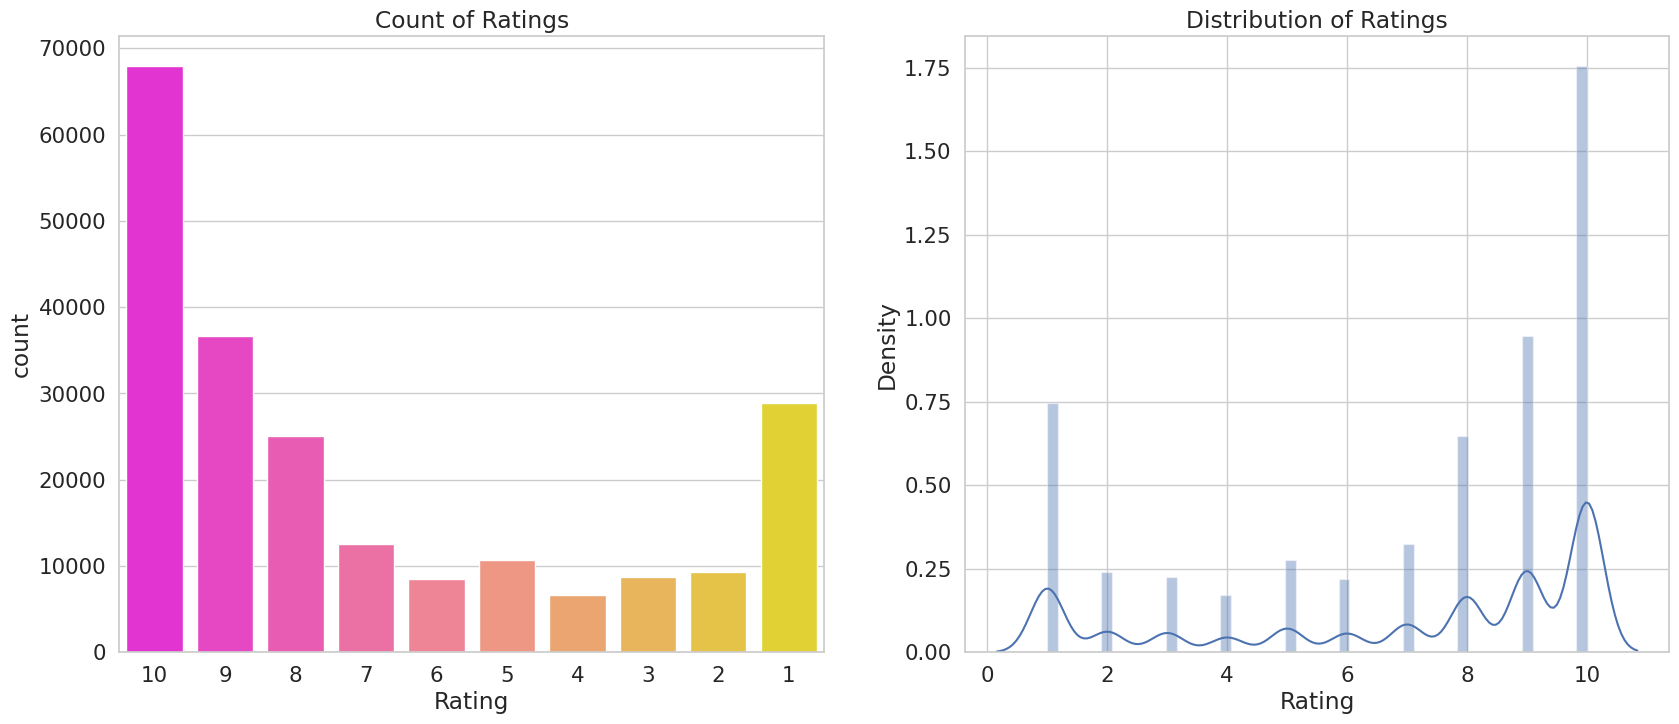

In [ ]:
# A countplot of the ratings so we can see the distribution of the ratings
plt.rcParams['figure.figsize'] = [20,8]
sns.set(font_scale = 1.4, style = 'whitegrid')
fig, ax = plt.subplots(1, 2)
sns_1 = sns.countplot(x='rating', data=df, palette='spring', order=list(range(10, 0, -1)), ax=ax[0])
sns_2 = sns.distplot(df['rating'], ax = ax[1])
sns_1.set_title('Count of Ratings')
sns_1.set_xlabel("Rating")

sns_2.set_title('Distribution of Ratings')
sns_2.set_xlabel("Rating")

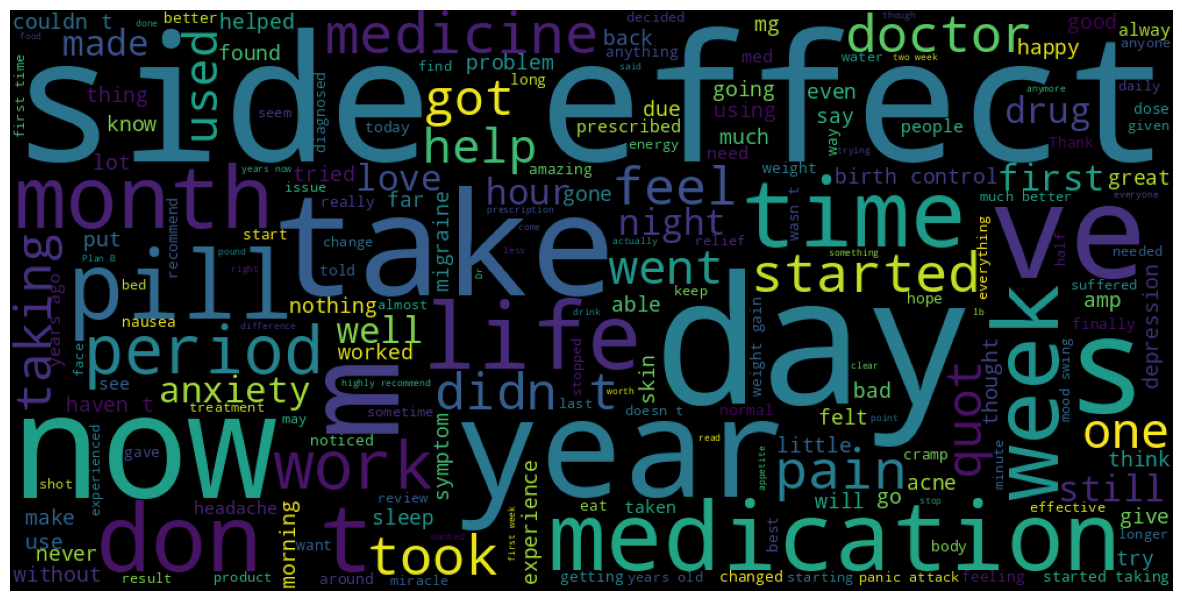

In [ ]:

#!pip install wordcloud
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 10
df_rate_ten = df.loc[df.rating == 10, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

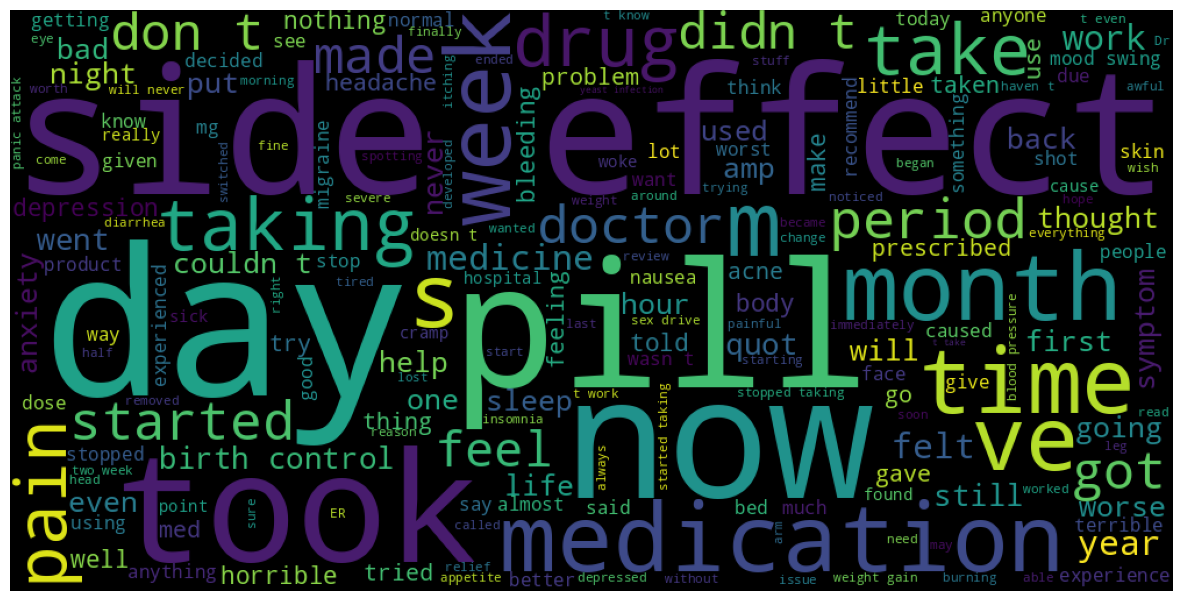

In [ ]:
from wordcloud import WordCloud# Word cloud of the reviews with rating equal to 1
df_rate_ten = df.loc[df.rating == 1, 'review']
k = (' '.join(df_rate_ten))

wordcloud = WordCloud(width = 1000, height = 500).generate(k)
plt.figure(figsize=(15, 10))
plt.imshow(wordcloud)
plt.axis('off');

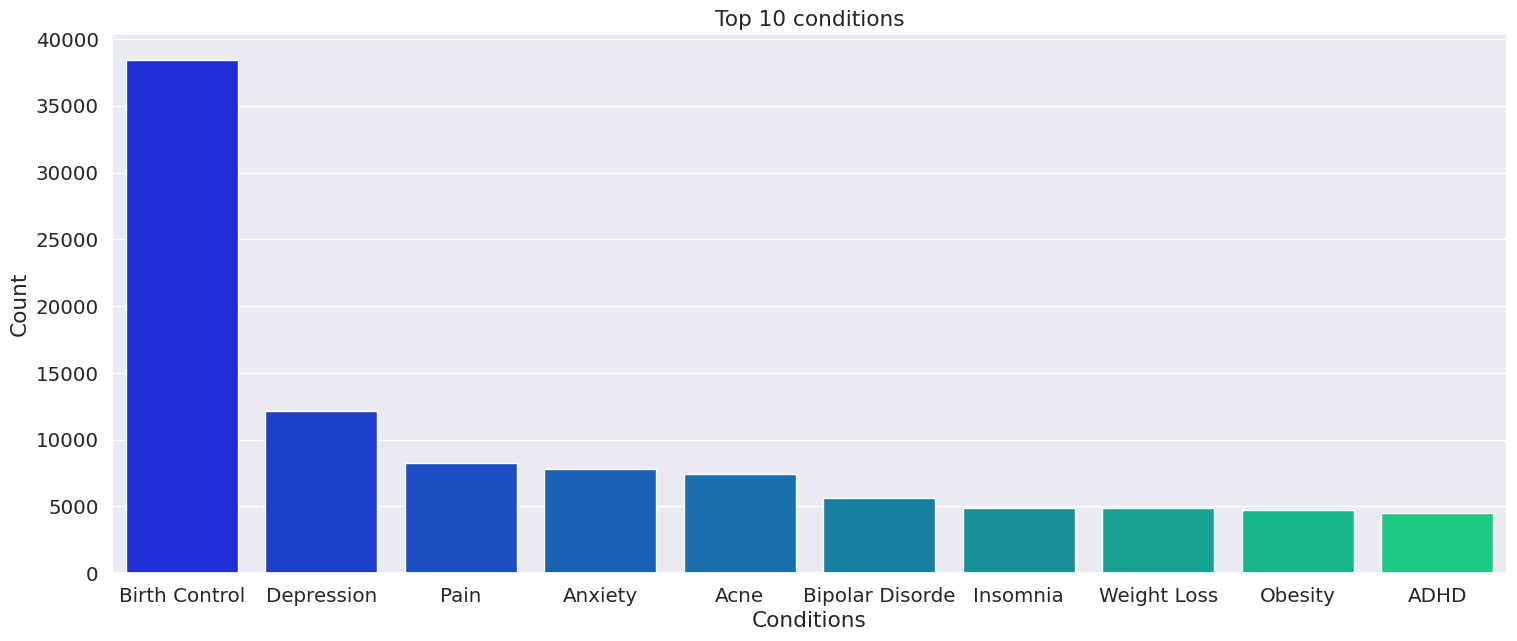

In [ ]:
# This barplot show the top 10 conditions the people are suffering.
cond = dict(df['condition'].value_counts())
top_condition = list(cond.keys())[0:10]
values = list(cond.values())[0:10]
sns.set(style = 'darkgrid', font_scale = 1.3)
plt.rcParams['figure.figsize'] = [18, 7]

sns_ = sns.barplot(x = top_condition, y = values, palette = 'winter')
sns_.set_title("Top 10 conditions")
sns_.set_xlabel("Conditions")
sns_.set_ylabel("Count");

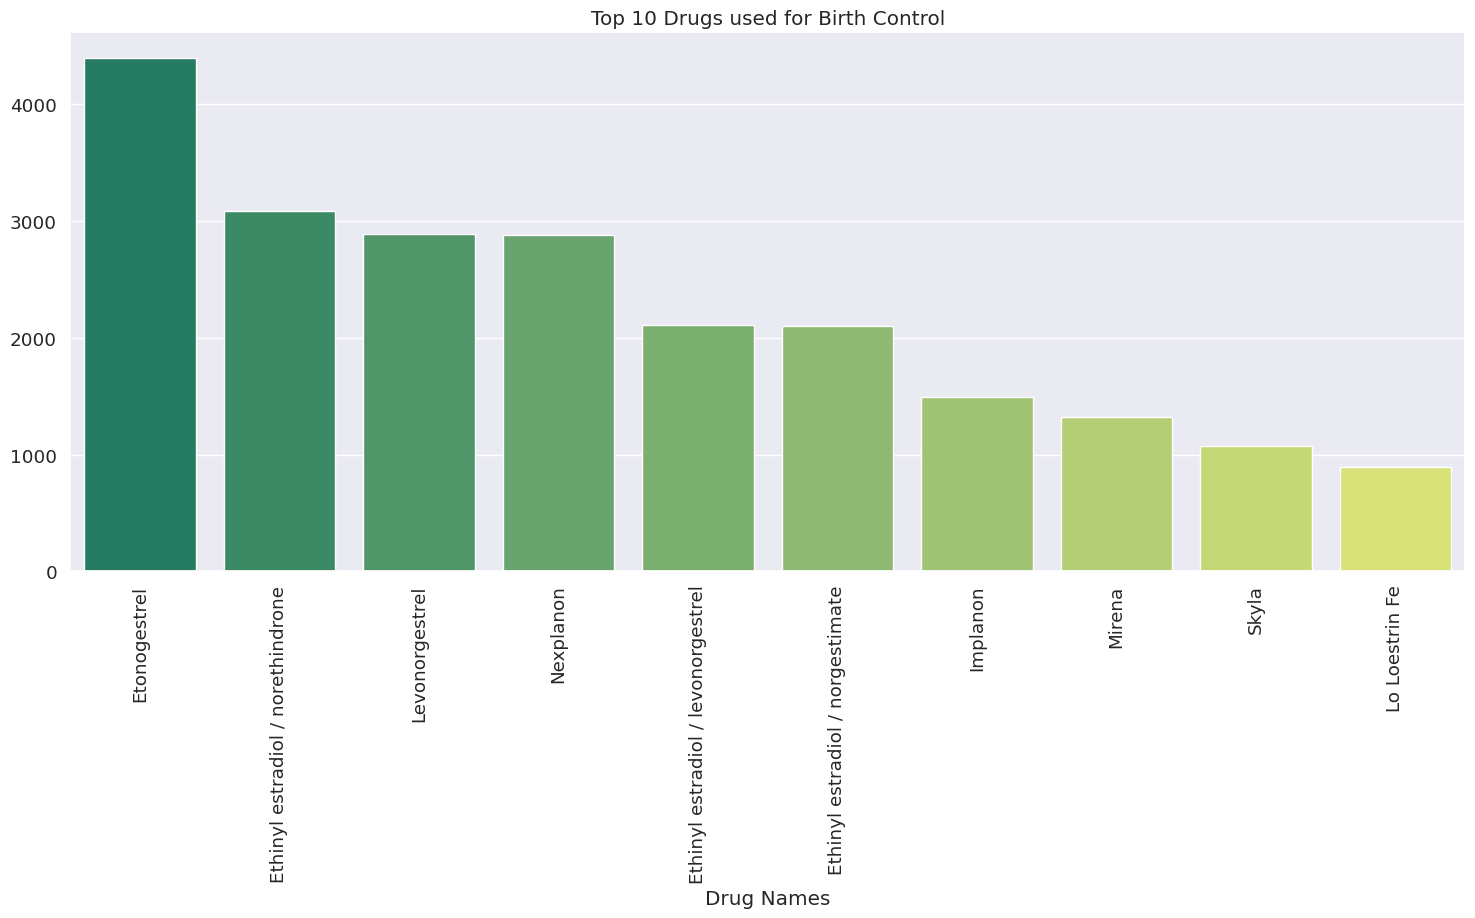

In [ ]:
# Top 10 drugs which are used for the top condition, that is Birth Control
df_cond_birth = df[df['condition'] == 'Birth Control']['drug name'].value_counts()[0: 10]
sns.set(font_scale = 1.2, style = 'darkgrid')

sns_ = sns.barplot(x = df_cond_birth.index, y = df_cond_birth.values, palette = 'summer')
sns_.set_xlabel('Drug Names')
sns_.set_title("Top 10 Drugs used for Birth Control")
plt.setp(sns_.get_xticklabels(), rotation = 90);

In [ ]:
df

,ID,drug name,condition,review,rating,date,useful count
0,206461,Valsartan,Left Ventricular Dysfunction,"""It has no side effect, I take it in combinati...",9,20-May-12,27
1,95260,Guanfacine,ADHD,"""My son is halfway through his fourth week of ...",8,27-Apr-10,192
2,92703,Lybrel,Birth Control,"""I used to take another oral contraceptive, wh...",5,14-Dec-09,17
3,138000,Ortho Evra,Birth Control,"""This is my first time using any form of birth...",8,3-Nov-15,10
4,35696,Buprenorphine / naloxone,Opiate Dependence,"""Suboxone has completely turned my life around...",9,27-Nov-16,37
...,...,...,...,...,...,...,...
53761,159999,Tamoxifen,"Breast Cancer, Prevention","""I have taken Tamoxifen for 5 years. Side effe...",10,13-Sep-14,43
53762,140714,Escitalopram,Anxiety,"""I&#039;ve been taking Lexapro (escitaploprgra...",9,8-Oct-16,11
53763,130945,Levonorgestrel,Birth Control,"""I&#039;m married, 34 years old and I have no ...",8,15-Nov-10,7
53764,47656,Tapentadol,Pain,"""I was prescribed Nucynta for severe neck/shou...",1,28-Nov-11,20


In [ ]:
df2 = df[df['useful count'] > 10]

In [ ]:
df_condition = df2.groupby(['condition'])['drug name'].nunique().sort_values(ascending=False)
df_condition = pd.DataFrame(df_condition).reset_index()
df_condition.tail(20)

,condition,drug name
706,64</span> users found this comment helpful.,1
707,92</span> users found this comment helpful.,1
708,Gastritis/Duodenitis,1
709,Esophageal Variceal Hemorrhage Prophylaxis,1
710,98</span> users found this comment helpful.,1
711,Severe Mood Dysregulation,1
712,Short Stature,1
713,Short Stature for Age,1
714,Meningitis,1
715,"Skin Disinfection, Preoperative",1


In [ ]:
df_condition_1 = df_condition[df_condition['drug name'] == 1].reset_index()

all_list = set(df.index)

# deleting them
condition_list = []
for i,j in enumerate(df['condition']):
    for c in list(df_condition_1['condition']):
        if j == c:
            condition_list.append(i)

new_idx = all_list.difference(set(condition_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']


In [ ]:
df.shape

(160684, 7)

In [ ]:
# removing the conditions with  in it.

all_list = set(df.index)
span_list = []
for i,j in enumerate(df['condition']):
    if "" in str(j):
        span_list.append(i)
new_idx = all_list.difference(set(span_list))
df = df.iloc[list(new_idx)].reset_index()
del df['index']

In [ ]:
import re
from bs4 import BeautifulSoup
import nltk
nltk.download('stopwords')
from nltk.corpus import stopwords
from nltk.stem.snowball import SnowballStemmer
from nltk.stem.porter import PorterStemmer

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


In [ ]:
# removing some stopwords from the list of stopwords as they are important for drug recommendation

stops = set(stopwords.words('english'))

not_stop = ["aren't","couldn't","didn't","doesn't","don't","hadn't","hasn't","haven't","isn't","mightn't",
            "mustn't","needn't","no","nor","not","shan't","shouldn't","wasn't","weren't","wouldn't"]
for i in not_stop:
    stops.remove(i)

In [ ]:
stemmer = SnowballStemmer('english')

def review_to_words(raw_review):
    # 1. Delete HTML
    review_text = BeautifulSoup(raw_review, 'html.parser').get_text()
    # 2. Make a space
    letters_only = re.sub('[^a-zA-Z]', ' ', review_text)
    # 3. lower letters
    words = letters_only.lower().split()
    # 5. Stopwords
    meaningful_words = [w for w in words if not w in stops]
    # 6. Stemming
    stemming_words = [stemmer.stem(w) for w in meaningful_words]
    # 7. space join words
    return( ' '.join(stemming_words))

# create a list of stopwords
nlp = spacy.load('en_core_web_sm')
stop_words = spacy.lang.en.stop_words.STOP_WORDS
parser = English()
punctuations = string.punctuation
# Creating our tokenizer function
def spacy_tokenizer(sentence):
    # Creating our token object, which is used to create documents with linguistic annotations.
    mytokens = parser(sentence)

    # Lemmatizing each token and converting each token into lowercase
    mytokens = [ word.lemma_.lower().strip() if word.lemma_ != "-PRON-" else word.lower_ for word in mytokens ]

    # Removing stop words
    mytokens = [ word for word in mytokens if word not in stop_words and word not in punctuations ]

    # return preprocessed list of tokens
    return mytokens

In [ ]:
%time df['review_clean'] = df['review'].apply(review_to_words)
df.head()

CPU times: user 2.69 ms, sys: 0 ns, total: 2.69 ms
Wall time: 2.64 ms


,ID,drug name,condition,review,rating,date,useful count,review_clean


In [ ]:
bow_vector = CountVectorizer(tokenizer = spacy_tokenizer, ngram_range=(1,2))
#  tf-idf vector
tfidf_vector = TfidfVectorizer(tokenizer = spacy_tokenizer)

In [ ]:
df.columns

Index(['ID', 'drug name', 'condition', 'review', 'rating', 'date',
       'useful count', 'review_clean', 'vaderReviewScore', 'vaderSentiment'],
      dtype='object')

In [ ]:
# part 1---vader sentiment analyzer for c_review
analyzer = SentimentIntensityAnalyzer()
# create new col vaderReviewScore based on C-review
df['vaderReviewScore'] = df['review_clean'].apply(lambda x: analyzer.polarity_scores(x)['compound'])

# define the positive, neutral and negative
positive_num = len(df[df['vaderReviewScore'] >=0.05])
neutral_num = len(df[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05)])
negative_num = len(df[df['vaderReviewScore']<=-0.05])

# create new col vaderSentiment based on vaderReviewScore
df['vaderSentiment'] = df['vaderReviewScore'].map(lambda x:int(2) if x>=0.05 else int(1) if x<=-0.05 else int(0) )
df['vaderSentiment'].value_counts() # 2-pos: 99519; 1-neg: 104434; 0-neu: 11110

# label pos/neg/neu based on vaderSentiment result
df.loc[df['vaderReviewScore'] >=0.05,"vaderSentimentLabel"] ="positive"
df.loc[(df['vaderReviewScore'] >-0.05) & (df['vaderReviewScore']<0.05),"vaderSentimentLabel"]= "neutral"
df.loc[df['vaderReviewScore']<=-0.05,"vaderSentimentLabel"] = "negative"

ValueError: ignored

In [ ]:
df['vaderReviewScore'].max()

nan